In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false; // disable scroll bar when displaying Folium map
}

<IPython.core.display.Javascript object>

# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Global Historical Climatology Network daily (GHCNd)](https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe - it's a wonderfully large dataset to play with! In particular, you will be asked to use data from the Ann Arbor Michigan location (my home!). and this is stored in the file: `assets/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`

Each row in this datafile corresponds to a single observation from a weather station, and has the following variables:
* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write a python notebook which plots line graphs of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015. (Based on the graph, do you think extreme weather is getting more frequent in 2015?)
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

I've written some steps I think would be good to go through, but there are other ways to solve this assignment so feel free to explore the pandas library! What I really want to see is an image that looks like this sketch I drew at my desk:

![](assets/chris_sketch.png)

In [2]:
#  I'll be using the folium package to render the data into a map in Jupyter.

import folium
import pandas as pd

# get the location information for this dataset
df = pd.read_csv('assets/BinSize_d400.csv')
station_locations_by_hash = df[df['hash'] == 'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89']

# get longitude and lattitude to plot
lons = station_locations_by_hash['LONGITUDE'].tolist()
lats = station_locations_by_hash['LATITUDE'].tolist()

# plot on a beautiful folium map
my_map = folium.Map(location = [lats[0], lons[0]], height = 500,  zoom_start = 9)
for lat, lon in zip(lats, lons):
    folium.Marker([lat, lon]).add_to(my_map)

# render map in Jupyter
display(my_map)

ModuleNotFoundError: No module named 'folium'

## Step 1
Load the dataset and transform the data into Celsius (refer to documentation) then extract all of the rows which have minimum or maximum temperatures.

__hint: when I did this step I had two DataFrame objects, each with ~80,000 entries in it__

In [3]:
import pandas as pd
df = pd.read_csv('assets/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')
df.head()

,ID,Date,Element,Data_Value
0,USW00094889,2014-11-12,TMAX,22
1,USC00208972,2009-04-29,TMIN,56
2,USC00200032,2008-05-26,TMAX,278
3,USC00205563,2005-11-11,TMAX,139
4,USC00200230,2014-02-27,TMAX,-106


In [4]:
# In this code cell, transform the Data_Value column
#First we convert fahrenheit to celcius
df["Data_Value"]=(df["Data_Value"]-32)*(5/9)

#Sorting data for easy understanding of the given data. No other usecase.
df=df.sort_values(by="Date")

#Initially dates are in string format. So we cannot apply datetime methods and libraries onto it. So we are converting the string
#to datetime formatting to solve the issue of application of datetime methods and libraries.
df["Date"]=pd.to_datetime(df["Date"])

#Applying condition, of removing 29th february from dataset.
BoolMask = (df['Date'].dt.month == 2) & (df['Date'].dt.day == 29)
df=df.drop(df[BoolMask].index)

#Making 2 dataframe one with max temp as elements and the other with min temps as elements. 
df_Tmax=df[df["Element"]=="TMAX"]
df_Tmin=df[df["Element"]=="TMIN"]

In [5]:
df_Tmax.head()

,ID,Date,Element,Data_Value
17153,USC00207320,2005-01-01,TMAX,65.555556
10073,USW00014833,2005-01-01,TMAX,0.555556
60994,USW00004848,2005-01-01,TMAX,56.111111
39454,USC00205563,2005-01-01,TMAX,-2.222222
18049,USW00014853,2005-01-01,TMAX,13.333333


In [6]:
df_Tmin.head()

,ID,Date,Element,Data_Value
60995,USW00004848,2005-01-01,TMIN,-17.777778
17155,USC00207320,2005-01-01,TMIN,-23.888889
10079,USW00014833,2005-01-01,TMIN,-42.222222
2812,USC00203712,2005-01-01,TMIN,-45.555556
24805,USW00094889,2005-01-01,TMIN,-48.888889


## Step 2
In order to visualize the data we would plot the min and max data for each day of the year between the years 2005 and 2014 across all weather stations. But we also need to find out when the min or max temperature in 2015 falls below the min or rises above the max for the previous decade.

If you did step 1 you have two Series objects with min and max times for the years 2005 through 2015. You can use Pandas `groupby` to create max and min temperature Series objects across all weather stations for each day of these years, and you can deal with the records for February 29 (the leap year) by dropping them.

__hint: when I finished this step, I had two DataFrame objects, each with exactly 4015 observations in them__

In [7]:
import numpy as np
Dates=[]
maxTemp=[]
minTemp=[]

#You see the last dataframes contains Tmax and Tmin for the same date measured via different stations. So here we are group them
#by dates and then we are finding the max and min among them(On daily basis) and then creating a new database out of it. Lets
#explore the code.


# create a DataFrame of maximum temperature by date
for i,j in df_Tmax.groupby("Date"):
    maxDaily=np.max(j["Data_Value"])
    Dates.append(i)
    maxTemp.append(maxDaily)
maxTempDatFrame=pd.DataFrame(maxTemp,index=Dates)


# create a DataFrame of minimum temperatures by date
for i,j in df_Tmin.groupby("Date"):
    minDaily=np.min(j["Data_Value"])
    minTemp.append(minDaily)
minTempDatFrame=pd.DataFrame(minTemp,index=Dates)

In [8]:
minTempDatFrame.head()

,0
2005-01-01,-48.888889
2005-01-02,-48.888889
2005-01-03,-17.777778
2005-01-04,-39.444444
2005-01-05,-70.000000


In [9]:
maxTempDatFrame.head()

,0
2005-01-01,68.888889
2005-01-02,59.444444
2005-01-03,56.111111
2005-01-04,3.888889
2005-01-05,0.555556


## Step 3
Now that you have grouped the daily max and min temperatures for each day of the years 2005 through 2015, you can separate out the data for 2015. Then you can use the Pandas `groupby` function to find the max and min of the temperature data for each __day of the year__ for the 2005-2014 data.

__hint: at the end of this step I had two DataFrames, one of maximum and the other of minimum values, which each had 365 observations in them. I also had another pair of similar DataFrames but only for the year 2015.__

In [10]:
#Step1: From the already available dataframe, we extract data for the years 2004-2014, for max temperatures.
BoolMask=maxTempDatFrame[maxTempDatFrame.index<'2015-01-01']
df_04_14_max=BoolMask
df_04_14_max.head()

,0
2005-01-01,68.888889
2005-01-02,59.444444
2005-01-03,56.111111
2005-01-04,3.888889
2005-01-05,0.555556


In [11]:
#Step2: Lets reset the index.
df_04_14_max=df_04_14_max.reset_index()
df_04_14_max.head()

,index,0
0,2005-01-01,68.888889
1,2005-01-02,59.444444
2,2005-01-03,56.111111
3,2005-01-04,3.888889
4,2005-01-05,0.555556


In [12]:
#Step3:Reset Index Names
df_04_14_max=df_04_14_max.rename(columns={"index":"Date",0:"Temp"})
df_04_14_max.head()

,Date,Temp
0,2005-01-01,68.888889
1,2005-01-02,59.444444
2,2005-01-03,56.111111
3,2005-01-04,3.888889
4,2005-01-05,0.555556


In [13]:
#Step4:Lets create Day,Month and Year columns. It will be handy later when we group the data.
df_04_14_max["Day"]=df_04_14_max["Date"].dt.day
df_04_14_max["Month"]=df_04_14_max["Date"].dt.month
df_04_14_max["Year"]=df_04_14_max["Date"].dt.year
df_04_14_max.head()

,Date,Temp,Day,Month,Year
0,2005-01-01,68.888889,1,1,2005
1,2005-01-02,59.444444,2,1,2005
2,2005-01-03,56.111111,3,1,2005
3,2005-01-04,3.888889,4,1,2005
4,2005-01-05,0.555556,5,1,2005


In [14]:
#Step5:Now understand what the issue in current database is. We have maximum temps for years 2004 to 2014. Means for every 
#particular date, say 1st Jan, there are 10 TMAX datas each corresponding for the year 2004-2014. What we need to do is
#find the max temp out of 10 temps available correponding to each year(2004-2014) And embed them into a new dataframe.
d_max_new=df_04_14_max.groupby(["Month","Day"]).max()
d_max_new.head(40)

Date        Temp  Year
Month Day                             
1     1   2014-01-01   68.888889  2014
      2   2014-01-02   59.444444  2014
      3   2014-01-03   56.111111  2014
      4   2014-01-04   41.111111  2014
      5   2014-01-05   53.333333  2014
      6   2014-01-06   87.222222  2014
      7   2014-01-07  102.777778  2014
      8   2014-01-08   90.000000  2014
      9   2014-01-09   81.111111  2014
      10  2014-01-10   37.777778  2014
      11  2014-01-11   68.888889  2014
      12  2014-01-12   71.666667  2014
      13  2014-01-13   75.000000  2014
      14  2014-01-14   65.555556  2014
      15  2014-01-15   19.444444  2014
      16  2014-01-16   34.444444  2014
      17  2014-01-17   56.111111  2014
      18  2014-01-18   50.000000  2014
      19  2014-01-19   41.111111  2014
      20  2014-01-20   56.111111  2014
      21  2014-01-21   56.111111  2014
      22  2014-01-22   47.222222  2014
      23  2014-01-23   53.333333  2014
      24  2014-01-24   47.222222  2014
      25  2014-01-25   37.777778  2014
      26  2014-01-26   31.666667  2014
      27  2014-01-27   25.555556  2014
      28  2014-01-28   50.000000  2014
      29  2014-01-29   81.111111  2014
      30  2014-01-30   83.888889  2014
      31  2014-01-31   62.222222  2014
2     1   2014-02-01   65.555556  2014
      2   2014-02-02   41.111111  2014
      3   2014-02-03   31.666667  2014
      4   2014-02-04   47.222222  2014
      5   2014-02-05   50.000000  2014
      6   2014-02-06   47.222222  2014
      7   2014-02-07   47.222222  2014
      8   2014-02-08   53.333333  2014
      9   2014-02-09   25.555556  2014

In [15]:
#Step6: Lets just reset the index for plotting purposes.
d_max_new=d_max_new.reset_index()
d_max_new.head(10)

,Month,Day,Date,Temp,Year
0,1,1,2014-01-01,68.888889,2014
1,1,2,2014-01-02,59.444444,2014
2,1,3,2014-01-03,56.111111,2014
3,1,4,2014-01-04,41.111111,2014
4,1,5,2014-01-05,53.333333,2014
5,1,6,2014-01-06,87.222222,2014
6,1,7,2014-01-07,102.777778,2014
7,1,8,2014-01-08,90.000000,2014
8,1,9,2014-01-09,81.111111,2014
9,1,10,2014-01-10,37.777778,2014


In [16]:
#Step1: From the already available dataframe, we extract data for the years 2004-2014, for min temperatures.
BoolMask1=minTempDatFrame[minTempDatFrame.index<'2015-01-01']
df_04_14_min=BoolMask1

#Step2: Lets reset the index.
df_04_14_min=df_04_14_min.reset_index()

##Step3:Reset Index Names
df_04_14_min=df_04_14_min.rename(columns={"index":"Date",0:"Temp"})

#Step4:Lets create Day,Month and Year columns. It will be handy later when we group the data.
df_04_14_min["Day"]=df_04_14_min["Date"].dt.day
df_04_14_min["Month"]=df_04_14_min["Date"].dt.month
df_04_14_min["Year"]=df_04_14_min["Date"].dt.year

#Step5:Now understand what the issue in current database is. We have minimum temps for years 2004 to 2014. Means for every 
#particular date, say 1st Jan, there are 10 TMIN datas each corresponding for the year 2004-2014. What we need to do is
#find the min temp out of 10 temps available correponding to each year(2004-2014) And embed them into a new dataframe.
d_min_new=df_04_14_min.groupby(["Month","Day"]).min()

#Step6: Lets just reset the index for plotting purposes.
d_min_new=d_min_new.reset_index()

In [17]:
d_min_new.head()

,Month,Day,Date,Temp,Year
0,1,1,2005-01-01,-106.666667,2005
1,1,2,2005-01-02,-166.111111,2005
2,1,3,2005-01-03,-166.111111,2005
3,1,4,2005-01-04,-162.777778,2005
4,1,5,2005-01-05,-101.111111,2005


In [18]:
# calculate the minimum and maximum values for the years 2015

#It here our condition is to work with data that only belong to the year 2015

#Step1: Extract the 2015 data. Here is how we do it.
df_2015_max=maxTempDatFrame[maxTempDatFrame.index>'2014-12-31']
df_2015_max.head()

,0
2015-01-01,-11.666667
2015-01-02,3.888889
2015-01-03,3.888889
2015-01-04,6.666667
2015-01-05,-2.222222


In [19]:
#Step2: Lets reset the index. This helps at the time of grouping the data day and month wise
df_2015_max=df_2015_max.reset_index()
df_2015_max.head()

,index,0
0,2015-01-01,-11.666667
1,2015-01-02,3.888889
2,2015-01-03,3.888889
3,2015-01-04,6.666667
4,2015-01-05,-2.222222


In [20]:
#Step3:Lets rename our indexes
df_2015_max=df_2015_max.rename(columns={"index":"Date",0:"Temp"})
df_2015_max.head()

,Date,Temp
0,2015-01-01,-11.666667
1,2015-01-02,3.888889
2,2015-01-03,3.888889
3,2015-01-04,6.666667
4,2015-01-05,-2.222222


In [21]:
#Step4:Lets create Day,Month and Year columns. It will be handy later when we group the data.
df_2015_max["Day"]=df_2015_max["Date"].dt.day
df_2015_max["Month"]=df_2015_max["Date"].dt.month
df_2015_max["Year"]=df_2015_max["Date"].dt.year
df_2015_max.head()

,Date,Temp,Day,Month,Year
0,2015-01-01,-11.666667,1,1,2015
1,2015-01-02,3.888889,2,1,2015
2,2015-01-03,3.888889,3,1,2015
3,2015-01-04,6.666667,4,1,2015
4,2015-01-05,-2.222222,5,1,2015


In [22]:
#Step5: Lets group data. This helps at the time of ploting
df_2015_max=df_2015_max.groupby(["Month","Day"]).max()
df_2015_max.head()

Date       Temp  Year
Month Day                            
1     1   2015-01-01 -11.666667  2015
      2   2015-01-02   3.888889  2015
      3   2015-01-03   3.888889  2015
      4   2015-01-04   6.666667  2015
      5   2015-01-05  -2.222222  2015

In [23]:
#Step6: Lets just reset the index for plotting purposes.
df_2015_max=df_2015_max.reset_index()
df_04_14_max.head()

,Date,Temp,Day,Month,Year
0,2005-01-01,68.888889,1,1,2005
1,2005-01-02,59.444444,2,1,2005
2,2005-01-03,56.111111,3,1,2005
3,2005-01-04,3.888889,4,1,2005
4,2005-01-05,0.555556,5,1,2005


In [24]:
#Since we only need to plot data that exceed previous 10 years, we run the command below.
df_2015_max_to_be_Plotted=df_2015_max[df_2015_max["Temp"]>d_max_new["Temp"]]
df_2015_max_to_be_Plotted.head()

,Month,Day,Date,Temp,Year
39,2,9,2015-02-09,28.333333,2015
106,4,17,2015-04-17,136.666667,2015
126,5,7,2015-05-07,152.222222,2015
127,5,8,2015-05-08,167.222222,2015
130,5,11,2015-05-11,152.222222,2015


In [25]:
#Step1: Extract the 2015 data. Here is how we do it.
df_2015_min=minTempDatFrame[minTempDatFrame.index>'2014-12-31']

#Step2: Lets reset the index. This helps at the time of grouping the data day and month wise
df_2015_min=df_2015_min.reset_index()

#Step3:Lets rename our indexes
df_2015_min=df_2015_min.rename(columns={"index":"Date",0:"Temp"})

#Step4:Lets create Day,Month and Year columns. It will be handy later when we group the data.
df_2015_min["Day"]=df_2015_min["Date"].dt.day
df_2015_min["Month"]=df_2015_min["Date"].dt.month
df_2015_min["Year"]=df_2015_min["Date"].dt.year

#Step5: Lets group data. This helps at the time of ploting
df_2015_min=df_2015_min.groupby(["Month","Day"]).max()

#Step6: Lets just reset the index for plotting purposes.
df_2015_min=df_2015_min.reset_index()

#Since we only need to plot data that is low than previous 10 years, we run the command below.
df_2015_min_to_be_Plotted=df_2015_min[df_2015_min["Temp"]<d_min_new["Temp"]]
df_2015_min_to_be_Plotted.head()

,Month,Day,Date,Temp,Year
4,1,5,2015-01-05,-103.888889,2015
10,1,11,2015-01-11,-128.888889,2015
33,2,3,2015-02-03,-150.000000,2015
44,2,14,2015-02-14,-150.555556,2015
45,2,15,2015-02-15,-162.222222,2015


## Step 4
Now it's time to plot! You need to explore matplotlib in order to plot line graphs of the min and max temperatures for the years 2005 through 2014 and to scatter plot __only__ the daily 2015 temperatures that exceeded those values.

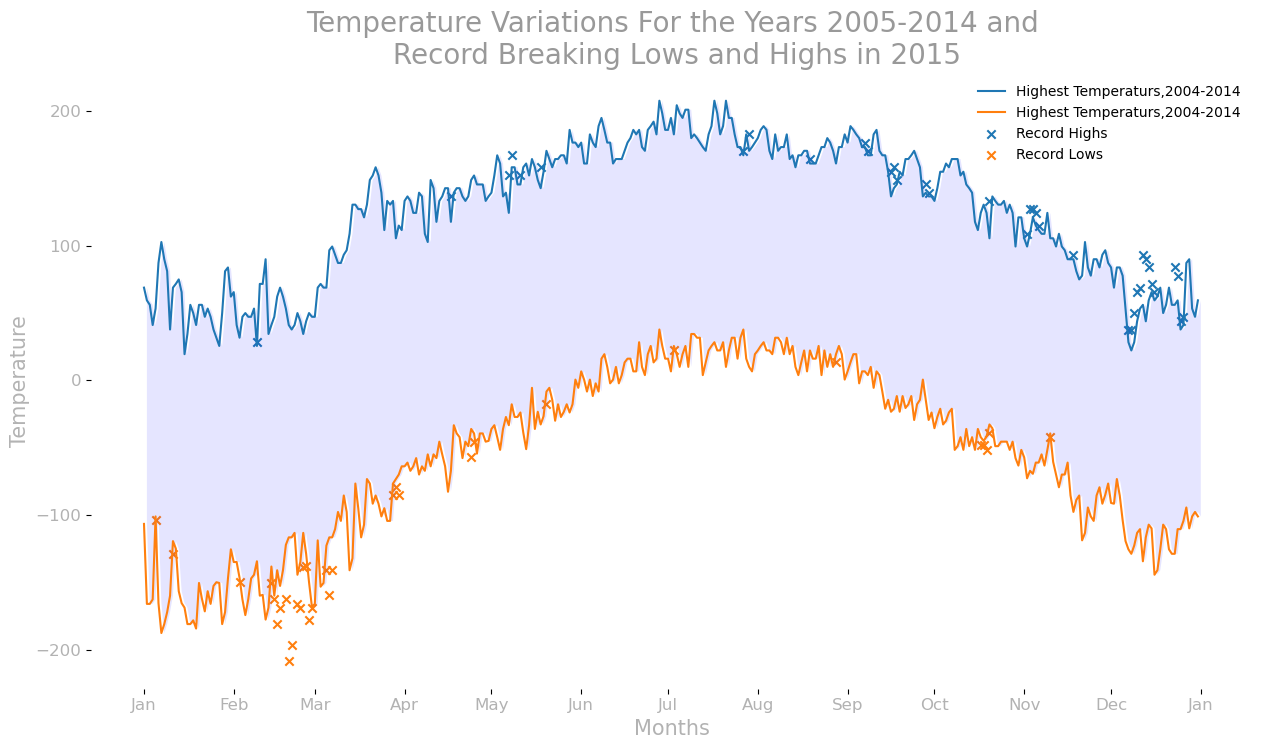

In [26]:
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
from calendar import month_abbr

#Basic Plotting Code
plt.figure(figsize=(15,8))
plt.plot(d_max_new.index,list(d_max_new["Temp"]))
plt.plot(d_min_new.index,list(d_min_new["Temp"]))
plt.scatter(df_2015_max_to_be_Plotted.index,list(df_2015_max_to_be_Plotted["Temp"]),marker='x',label="Irregularly High Temperatures")
plt.scatter(df_2015_min_to_be_Plotted.index,list(df_2015_min_to_be_Plotted["Temp"]),marker='x',label="Irregularly Low Temperatures")


#Code to convert 1 to 365 tooo January to December
dates = pd.date_range(start='2015-01-01', periods=365)
# Set the custom tick positions and labels for the x-axis
locator = MonthLocator()  # Set the locator to group ticks by month
formatter = DateFormatter("%b")  # Use the abbreviated month name as the tick label
plt.gca().xaxis.set_major_locator(locator)  # Set the major locator for the x-axis
plt.gca().xaxis.set_major_formatter(formatter)  # Set the formatter for the x-axis


#This code handles the label.
plt.xlabel("Months",fontsize=15,alpha=0.3)
plt.ylabel("Temperature",fontsize=15,alpha=0.3)
plt.xticks(fontsize=12,alpha=0.3)
plt.yticks(fontsize=12,alpha=0.3)
plt.title("Temperature Variations For the Years 2005-2014 and\n Record Breaking Lows and Highs in 2015",fontsize=20,alpha=0.4)
plt.legend(["Highest Temperaturs,2004-2014","Highest Temperaturs,2004-2014","Record Highs","Record Lows"],frameon=False)

#Code to fill the space between two plots
ax=plt.gca().spines
for i in ax.values():
    i.set_visible(False)
plt.gca().fill_between(range(1,366),list(d_max_new["Temp"]),list(d_min_new["Temp"]),facecolor='blue',alpha=0.1)
plt.show()